In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
from random import shuffle,choice

import cv2
from matplotlib import pylab as plt

import keras
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical

from utils import rgb2tensor,grey2rgb,preprocess_mnist,plot_list

Using Theano backend.


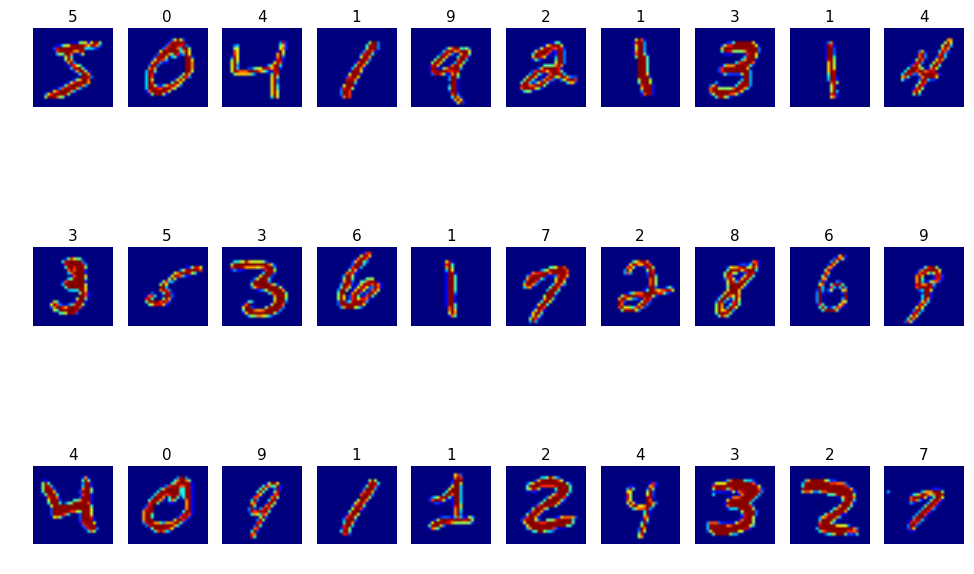

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

plot_list(img_list= X_train[:30],
          labels = y_train[:30],
          cols_nr=10)

In [3]:
X_train = np.expand_dims(X_train,axis = 1).transpose(0,2,3,1)/255.
X_test = np.expand_dims(X_test,axis = 1).transpose(0,2,3,1)/255.

In [6]:
def create_addition_dataset(X_train,y_train,subset = None):
    if subset:
        X_train = X_train[:subset]
        y_train = y_train[:subset]
        
    tr1 = zip(X_train, y_train) 
    tr2 = zip(X_train, y_train) 
    shuffle(tr1)
    shuffle(tr2)
    
    X_train_1,X_train_2,y_train_12 = [],[],[]
    for t1,t2 in zip(tr1,tr2):
        x1,y1 = t1
        x2,y2 = t2
        y = y1+y2
        X_train_1.append(x1)
        X_train_2.append(x2)
        y_train_12.append(y)
    X_train_1 = np.stack(X_train_1)
    X_train_2 = np.stack(X_train_2)
    y_train_12 = np.stack(y_train_12)
    return X_train_1,X_train_2,y_train_12

In [77]:
X_train_1,X_train_2,y_train_12 = create_addition_dataset(X_train,y_train,subset = 100)
X_test_1,X_test_2,y_test_12 = create_addition_dataset(X_test,y_test,subset = 100)

In [8]:
X_train_1.shape

(20000, 28, 28, 1)

In [14]:
def create_img2img_addition_dataset(X_train,y_train,subset = None):
    _,h,w,c = X_train.shape
    if subset:
        X_train = X_train[:subset]
        y_train = y_train[:subset] 
        
    X_train_dict = {i:[] for i in range(10)}
    for i,(x,y) in enumerate(zip(X_train,y_train)):
        X_train_dict[y] = X_train_dict[y] + [x]
    
    tr1 = zip(X_train, y_train) 
    tr2 = zip(X_train, y_train) 
    shuffle(tr1)
    shuffle(tr2)
    
    X_train_1,X_train_2,y_train_12 = [],[],[]
    for t1,t2 in zip(tr1,tr2):
        x1,y1 = t1
        x2,y2 = t2
        y = str(y1+y2)
        if len(y) == 2:
            result_digit_1 = choice(X_train_dict[int(y[0])])
            result_digit_2 = choice(X_train_dict[int(y[1])])
            sum_img = np.zeros((h,44,c))
            sum_img[:,:w-6,:] = result_digit_1[:,3:w-3,:]
            sum_img[:,w-6:,:] = result_digit_2[:,3:w-3,:]
        elif len(y) == 1:
            sum_img = choice(X_train_dict[int(y)])
        else:
            raise ValueError("wrong digit length")
        sum_img = cv2.resize(sum_img,(28,28))
        sum_img = np.expand_dims(sum_img,axis = 2)
            
        X_train_1.append(x1)
        X_train_2.append(x2)
        y_train_12.append(sum_img)
    X_train_1 = np.stack(X_train_1)
    X_train_2 = np.stack(X_train_2)
    y_train_12 = np.stack(y_train_12)

    return X_train_1,X_train_2,y_train_12

In [15]:
X_train_1,X_train_2,y_train_12 = create_img2img_addition_dataset(X_train,y_train,subset = 60000)
X_test_1,X_test_2,y_test_12 = create_img2img_addition_dataset(X_test,y_test,subset = 5000)

In [ ]:
def plot_results(X1,X2,Y,model,nr_of_imgs):
    if model:
        predicted_sum_img = model.predict([X1[:nr_of_imgs],
                                           X2[:nr_of_imgs]])

        for i,(x1,x2,t,s) in enumerate(zip(X1[:nr_of_imgs],
                                           X2[:nr_of_imgs],
                                           Y[:nr_of_imgs],
                                           predicted_sum_img[:nr_of_imgs])):
            plot_list([x1[:,:,0],x2[:,:,0],t[:,:,0],s[:,:,0]],
                      labels = range(4), cols_nr =4,
                      plot_config=plt.figure(figsize = (5,5)))
    else:
        for i,(x1,x2,t) in enumerate(zip(X1[:nr_of_imgs],
                                           X2[:nr_of_imgs],
                                           Y[:nr_of_imgs])):
            plot_list([x1[:,:,0],x2[:,:,0],t[:,:,0]],
                      labels = range(3), cols_nr =3,
                      plot_config=plt.figure(figsize = (5,5)))


class PlotPredictionImgCallback(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        plot_results(X_test_1,X_test_2,y_test_12,addition_model,nr_of_imgs = 5)

Train on 60000 samples, validate on 5000 samples
Epoch 1/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0905

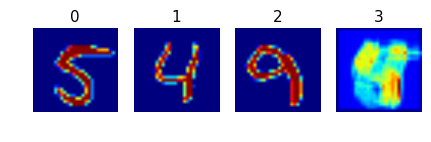

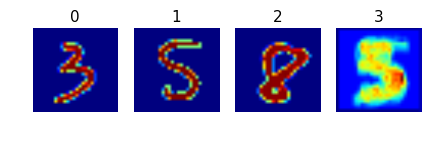

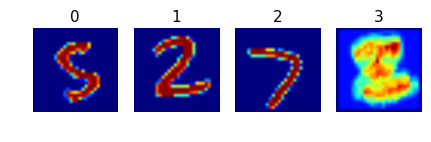

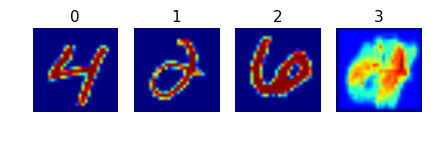

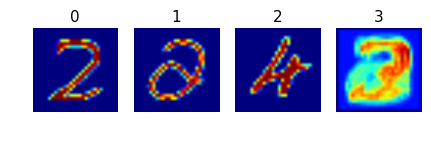

60000/60000 [==============================] - 373s - loss: 0.0905 - val_loss: 0.0784
Epoch 2/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0823

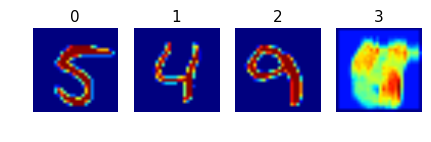

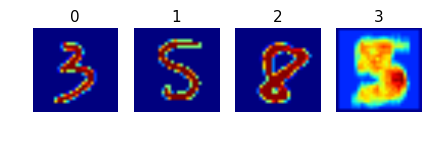

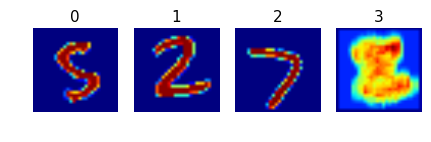

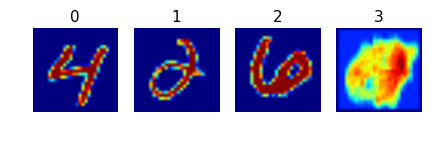

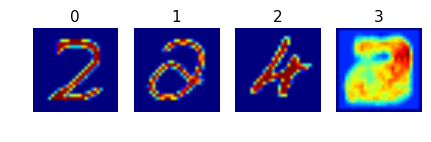

60000/60000 [==============================] - 263s - loss: 0.0823 - val_loss: 0.0774
Epoch 3/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0818

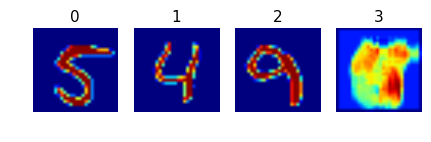

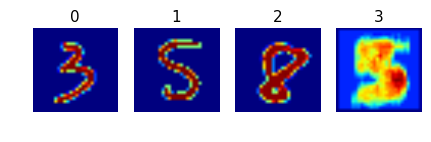

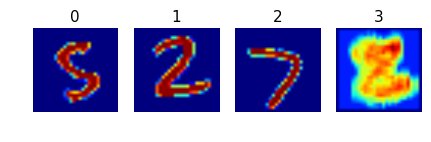

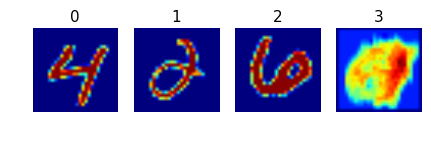

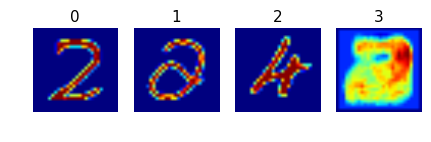

60000/60000 [==============================] - 189s - loss: 0.0818 - val_loss: 0.0771
Epoch 4/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0816

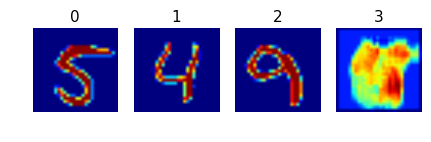

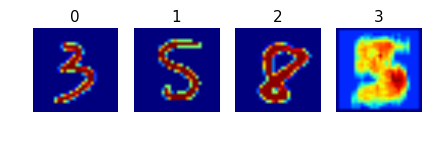

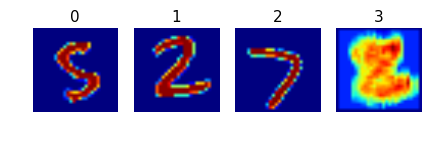

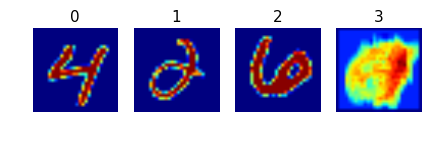

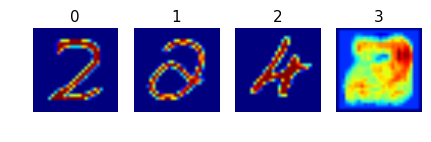

60000/60000 [==============================] - 191s - loss: 0.0816 - val_loss: 0.0770
Epoch 5/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0815

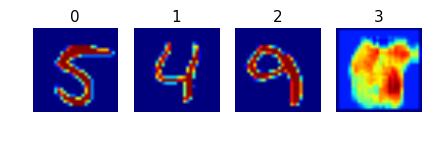

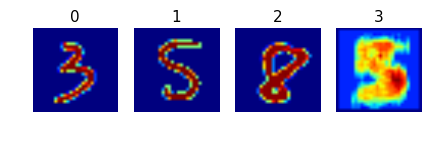

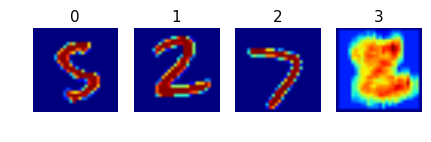

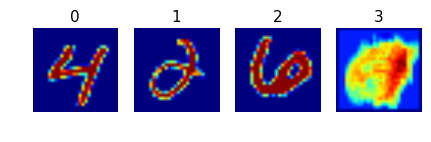

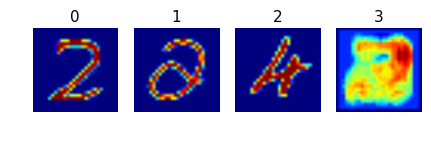

60000/60000 [==============================] - 189s - loss: 0.0815 - val_loss: 0.0771
Epoch 6/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0814

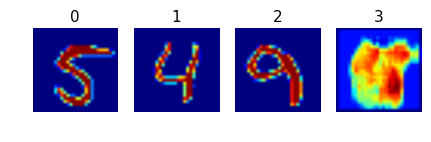

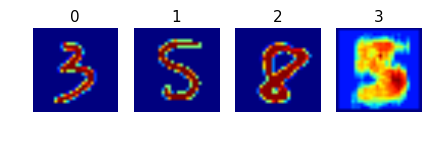

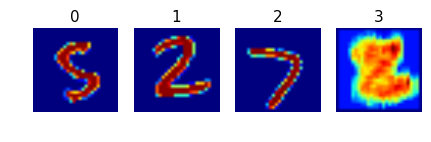

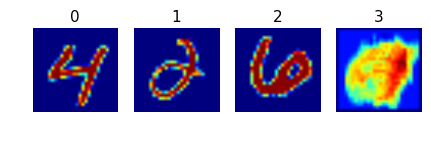

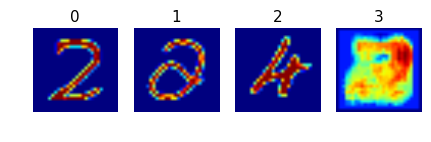

60000/60000 [==============================] - 189s - loss: 0.0815 - val_loss: 0.0770
Epoch 7/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0814

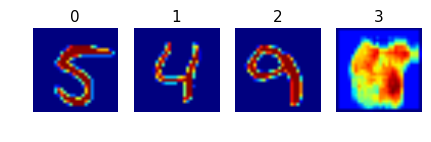

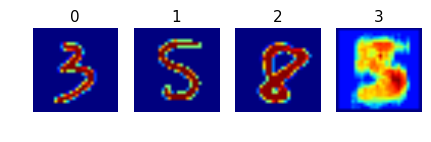

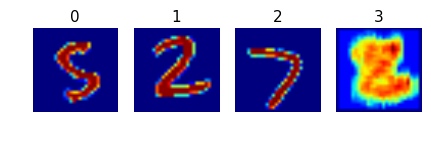

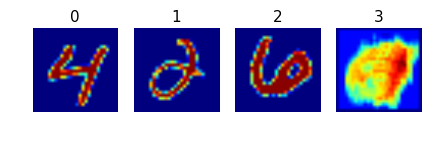

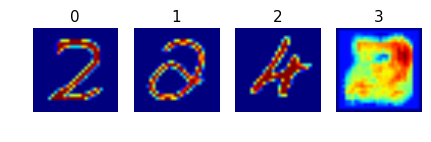

60000/60000 [==============================] - 190s - loss: 0.0814 - val_loss: 0.0770
Epoch 8/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0813

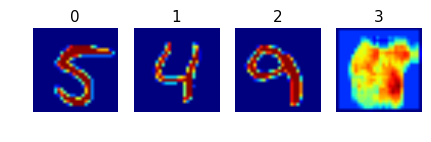

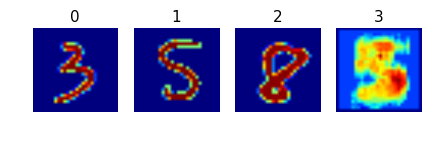

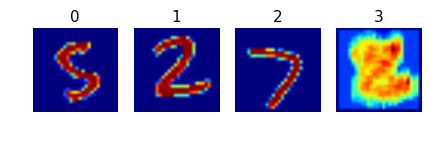

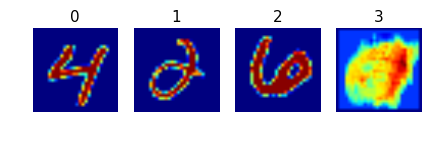

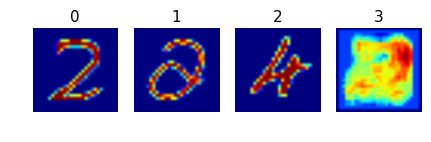

60000/60000 [==============================] - 190s - loss: 0.0813 - val_loss: 0.0769
Epoch 9/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0813

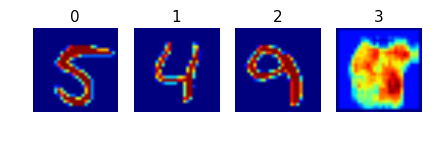

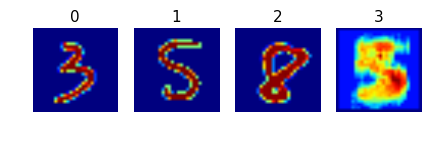

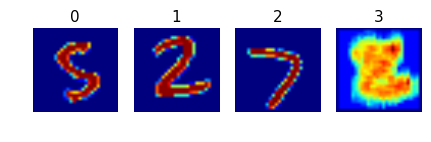

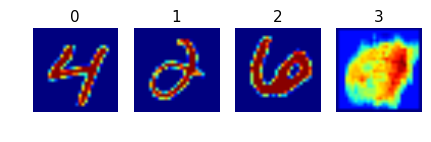

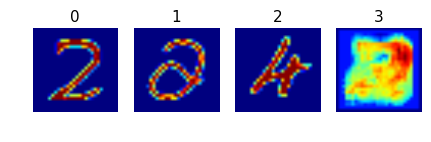

60000/60000 [==============================] - 193s - loss: 0.0813 - val_loss: 0.0767
Epoch 10/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0812

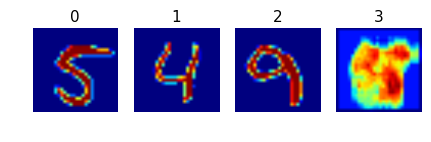

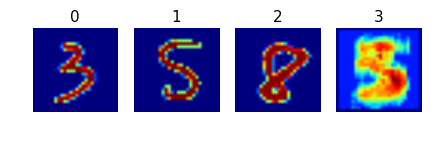

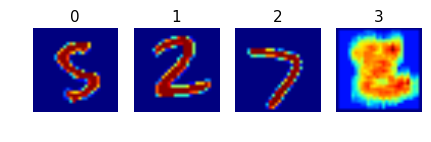

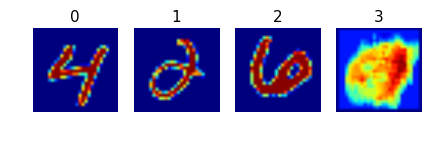

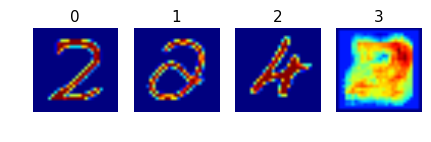

60000/60000 [==============================] - 189s - loss: 0.0812 - val_loss: 0.0767
Epoch 11/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0812

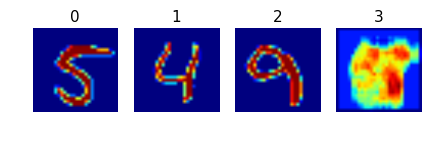

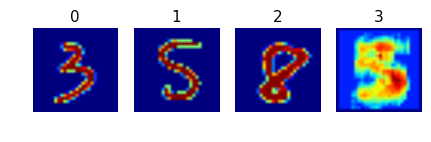

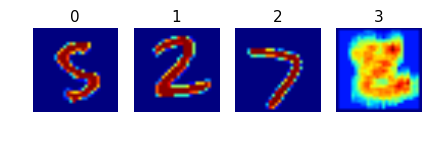

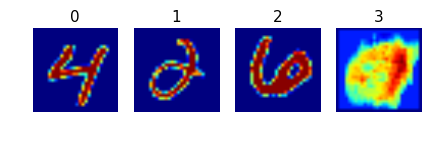

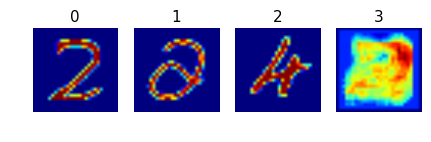

60000/60000 [==============================] - 188s - loss: 0.0812 - val_loss: 0.0766
Epoch 12/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0811

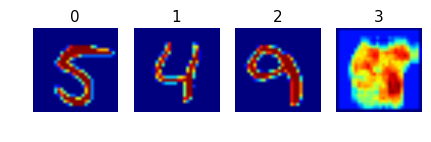

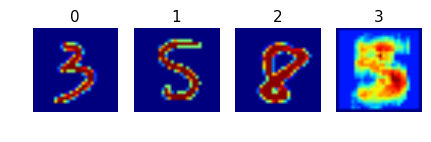

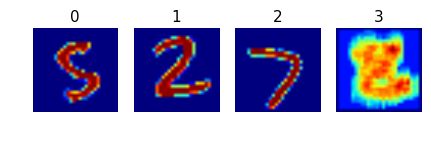

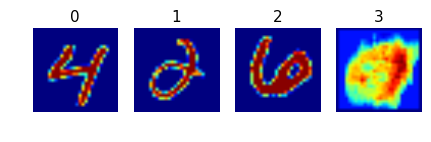

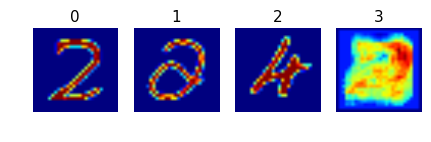

60000/60000 [==============================] - 191s - loss: 0.0811 - val_loss: 0.0765
Epoch 13/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0811

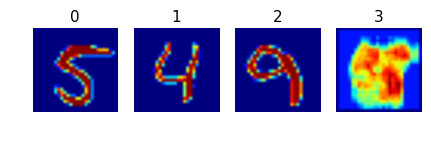

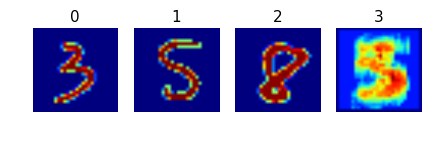

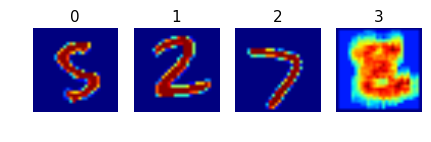

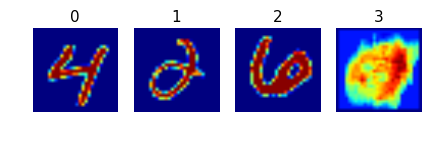

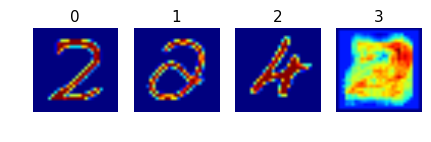

60000/60000 [==============================] - 189s - loss: 0.0811 - val_loss: 0.0765
Epoch 14/100
59904/60000 [============================>.] - ETA: 0s - loss: 0.0811

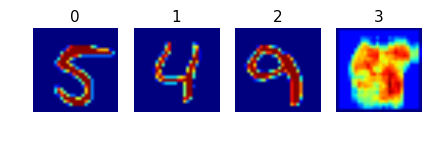

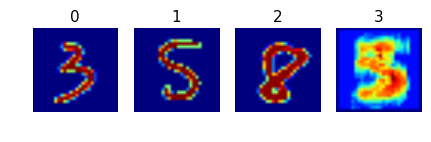

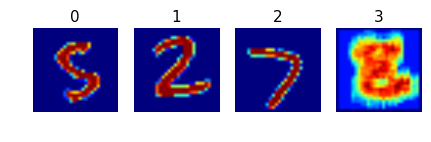

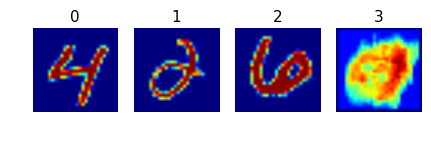

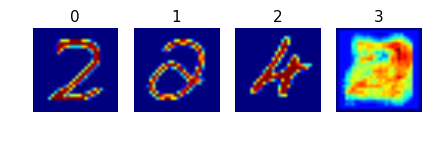

60000/60000 [==============================] - 194s - loss: 0.0811 - val_loss: 0.0766
Epoch 15/100
58112/60000 [============================>.] - ETA: 6s - loss: 0.0810

In [ ]:
from keras.layers import Input, Dense, Conv2D, Flatten, Dropout, UpSampling2D,merge
from keras.models import Model
from keras.callbacks import ModelCheckpoint,Callback

NB_EPOCHS = 100
BATCH_SIZE = 128
MODEL_PATH = os.path.join("models","addition_model.h5")

digit_input = Input(shape=(28, 28, 1))
x = Conv2D(16,3,3, activation='relu',border_mode = "same")(digit_input)
out = Conv2D(32,1,1, activation='relu',border_mode = "same")(x)

feature_extractor = Model(digit_input, out)

digit_1 = Input(shape=(28, 28, 1))
digit_2 = Input(shape=(28, 28, 1))

out_1 = feature_extractor(digit_1)
out_2 = feature_extractor(digit_2)

summed = merge([out_1, out_2], mode='sum')
x = Conv2D(64,3,3, activation='relu',border_mode = "same")(summed)
out = Conv2D(1,1,1, activation='sigmoid',border_mode = "same")(x)

addition_model = Model([digit_1, digit_2], out)
addition_model.compile(optimizer='adam',loss='mse')

plot_predictions = PlotPredictionImgCallback()
model_checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', verbose=0, 
                                   save_best_only=True, save_weights_only=False, mode='auto')
addition_model.fit([X_train_1,X_train_2],y_train_12, 
          validation_data = [[X_test_1,X_test_2],y_test_12],
          nb_epoch = NB_EPOCHS,
          batch_size = BATCH_SIZE,
          verbose = 1,
          callbacks = [model_checkpoint,plot_predictions]
         )

In [ ]:
plot_results(X_test_1,X_test_2,y_test_12,model = None,nr_of_imgs = 5)